In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

from itertools import chain
from skimage import io

In [22]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')

sample_df = pd.read_csv('sample_labels.csv')

In [3]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
35948,00009485_002.png,Mass,2,9485,60,M,AP,2500,2048,0.168,0.168,NaN
40162,00010478_006.png,Edema|Pneumonia,6,10478,55,F,AP,2500,2048,0.168,0.168,NaN
17510,00004724_007.png,No Finding,7,4724,50,M,AP,2500,2048,0.171,0.171,NaN


In [4]:
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4411,00021818_026.png,Consolidation|Pneumonia,26,21818,037Y,M,PA,2992,2991,0.143,0.143
3020,00014844_005.png,Consolidation|Infiltration,5,14844,067Y,F,PA,2992,2991,0.143,0.143
1589,00008267_000.png,Fibrosis,0,8267,064Y,M,PA,2500,2048,0.168,0.168


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

# Demographic data 

The patient demographic data such as gender, age, patient position,etc. (as it is available)

<AxesSubplot: title={'center': 'Age Distribution'}, xlabel='Age'>

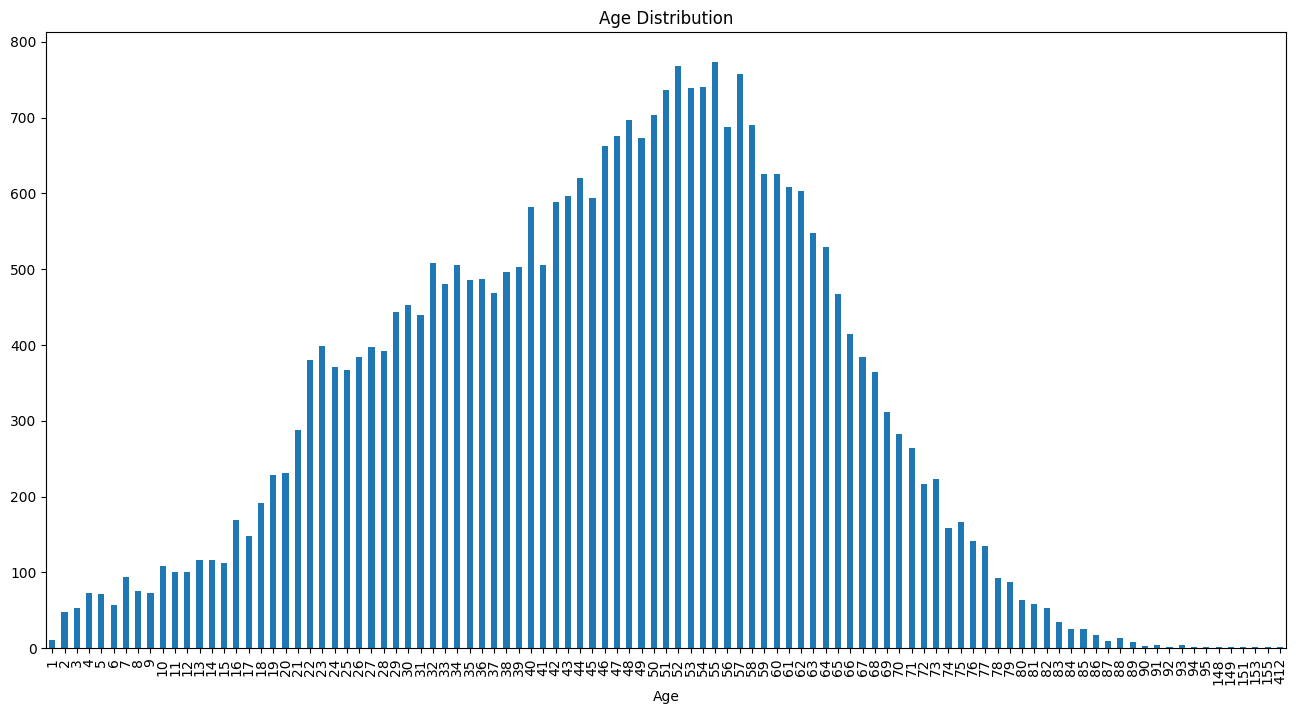

In [5]:
# First we need to remove duplicate patient ID data
plt.figure(figsize=(16,8))

plt.title("Age Distribution")
     
# label of x-axis
plt.xlabel("Age")

(all_xray_df
    [all_xray_df['Follow-up #'] == 0]
    ['Patient Age']
    .value_counts()
    .sort_index()
    .plot(kind='bar'))

<AxesSubplot: title={'center': 'Age Distribution'}, xlabel='Age'>

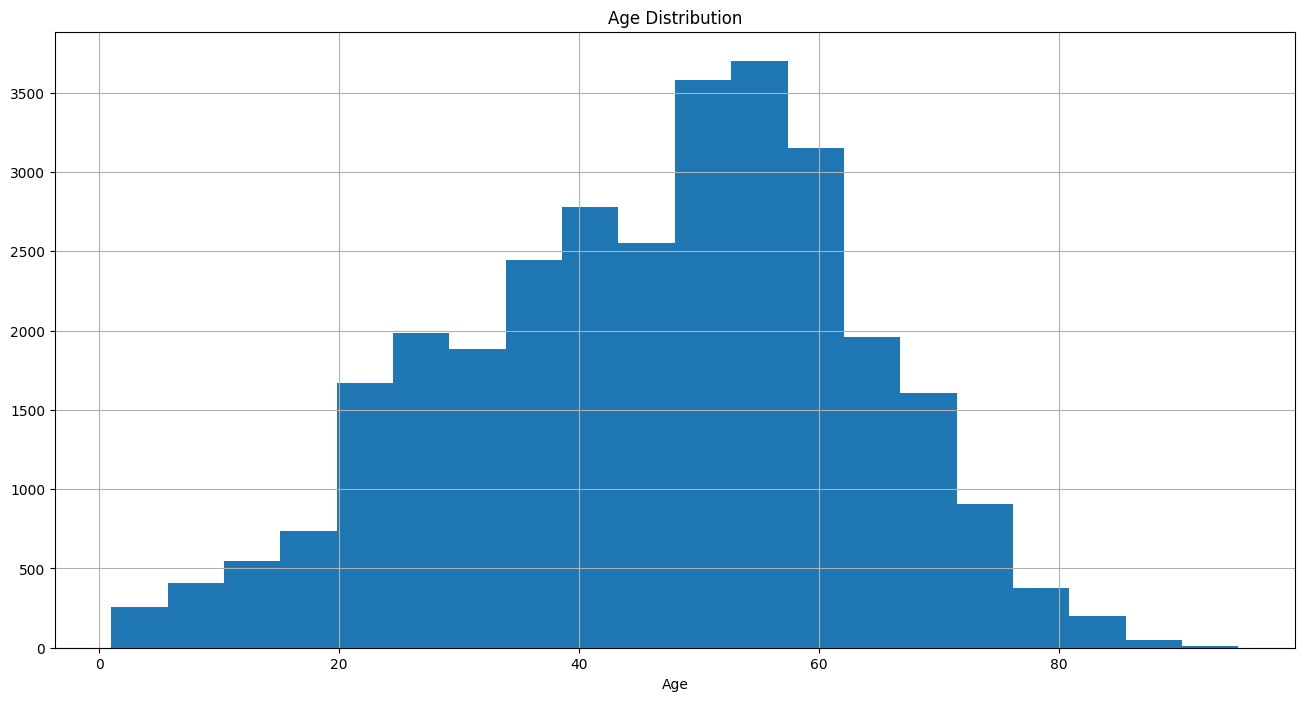

In [6]:
# First we need to remove duplicate patient ID data
plt.figure(figsize=(16,8))

plt.title("Age Distribution")
     
# label of x-axis
plt.xlabel("Age")

(all_xray_df
    [(all_xray_df['Follow-up #'] == 0) & (all_xray_df['Patient Age'] <= 100)]
    ['Patient Age']
    .hist(bins=20)
)

<AxesSubplot: title={'center': 'gENDER Distribution'}>

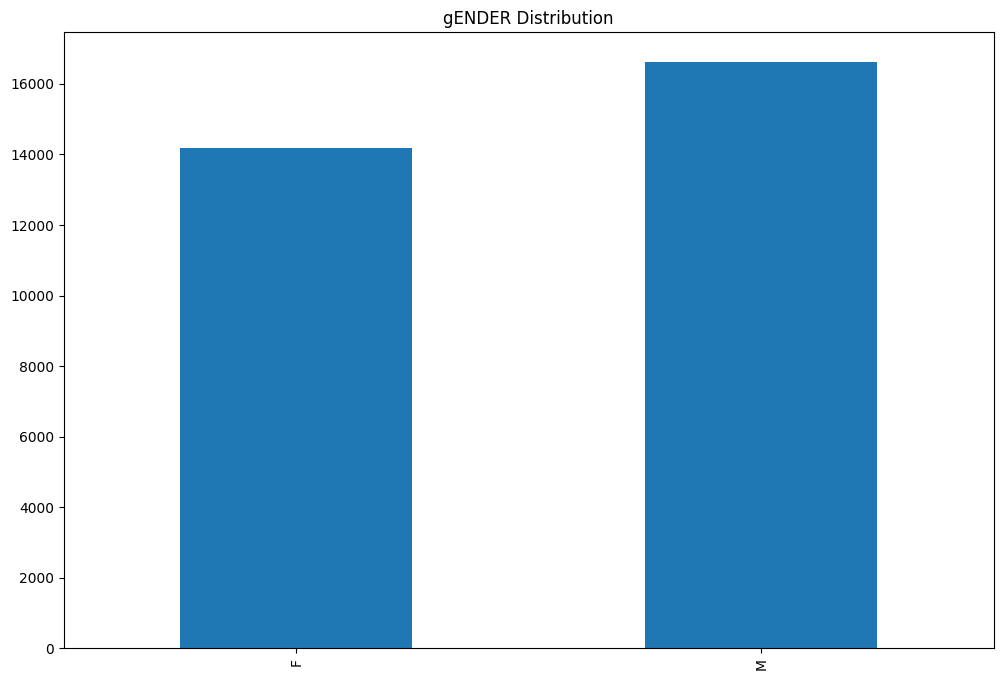

In [7]:
plt.figure(figsize=(12,8))

plt.title("gENDER Distribution")

(all_xray_df
    [all_xray_df['Follow-up #'] == 0]
    ['Patient Gender']
    .value_counts()
    .sort_index()
    .plot(kind='bar'))

<AxesSubplot: title={'center': 'gENDER Distribution'}>

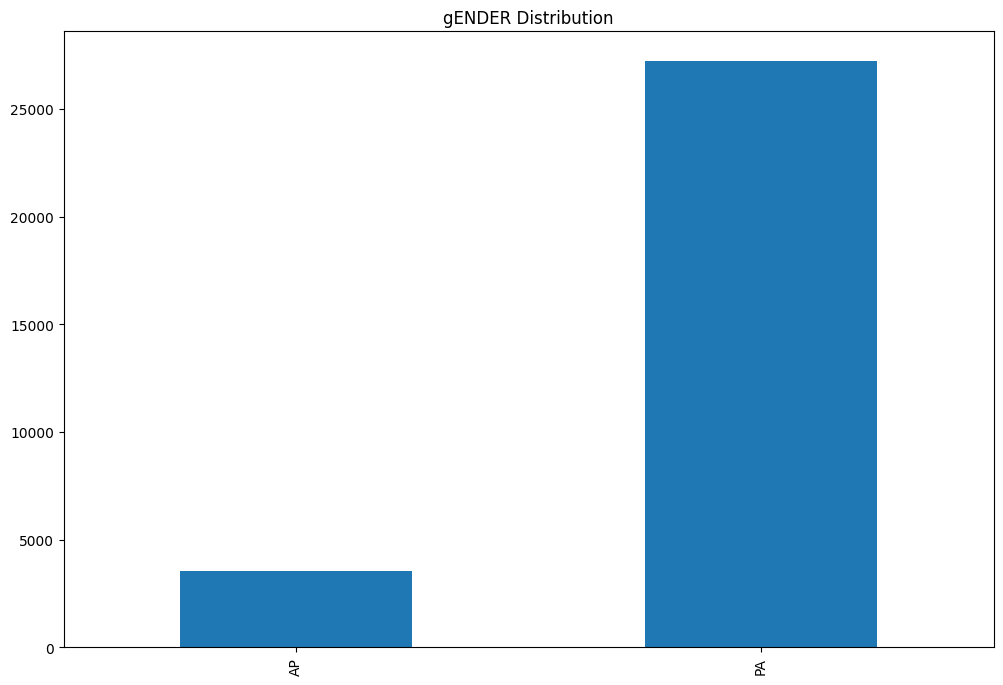

In [8]:
plt.figure(figsize=(12,8))

plt.title("gENDER Distribution")

(all_xray_df
    [all_xray_df['Follow-up #'] == 0]
    ['View Position']
    .value_counts()
    .sort_index()
    .plot(kind='bar'))

# Case popularity

The number of cases including:
number of pneumonia cases,
number of non-pneumonia cases

In [13]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
76244,00018716_007.png,No Finding,7,18716,62,M,PA,2488,2988,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
44242,00011391_020.png,Consolidation|Infiltration,20,11391,39,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28536,00007443_000.png,No Finding,0,7443,51,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<AxesSubplot: >

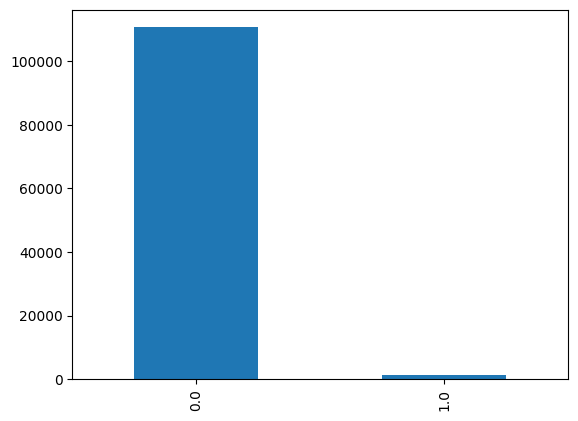

In [14]:
all_xray_df['Pneumonia'].value_counts().plot(kind='bar')

# Other diseases distributions

The distribution of other diseases that are comorbid with pneumonia

<AxesSubplot: >

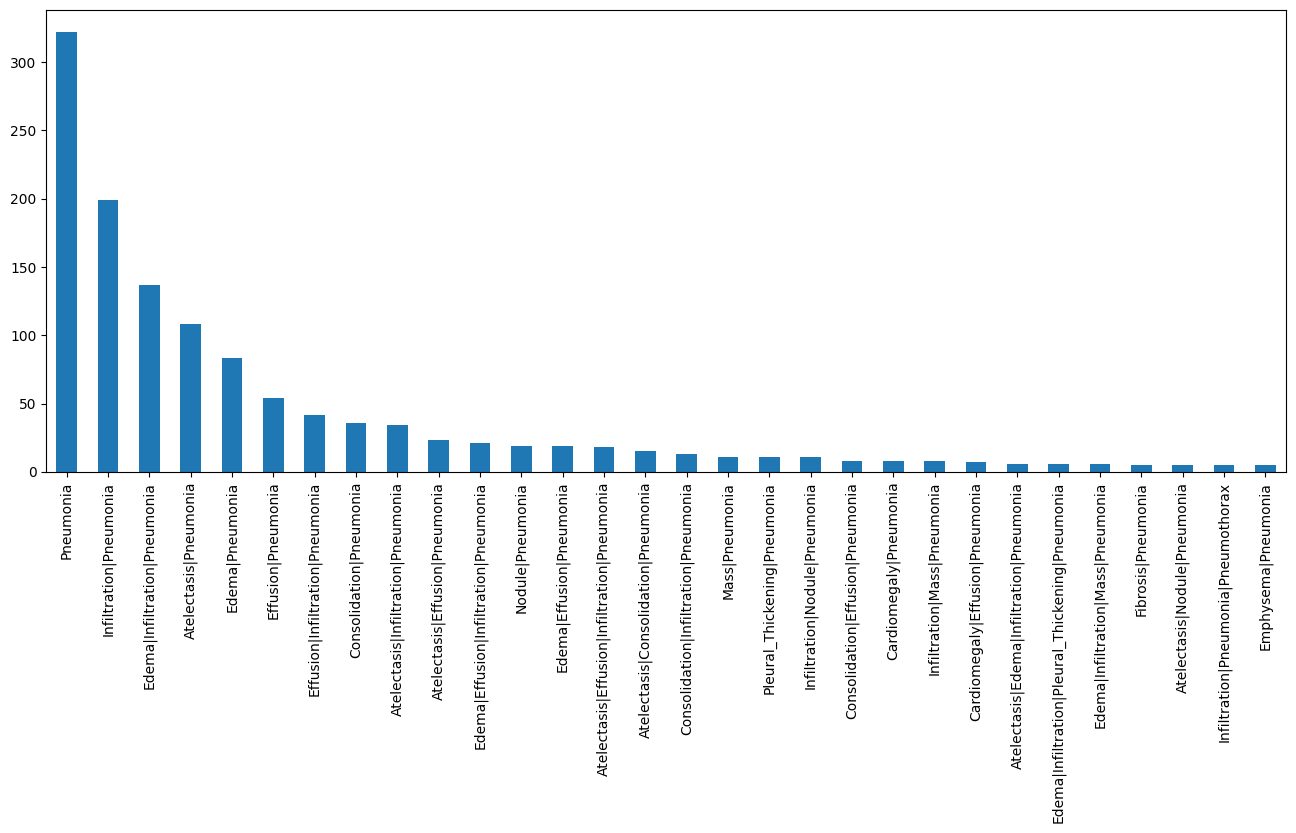

In [15]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df['Pneumonia']==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

# Diseases per patients

Number of disease per patient

In [16]:
diseases_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

all_xray_df['Total Diseases'] = all_xray_df.loc[:, diseases_labels].sum(axis = 1)

<AxesSubplot: >

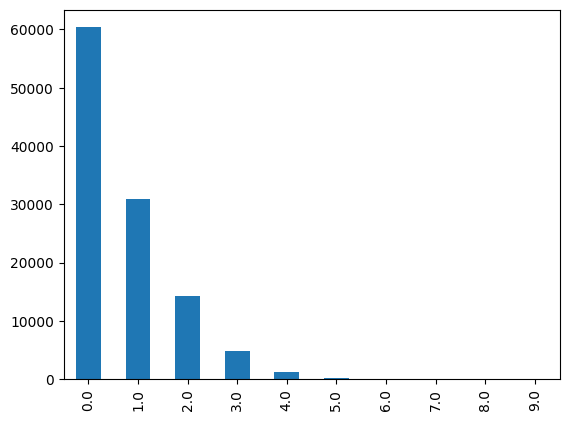

In [17]:
(all_xray_df['Total Diseases'].value_counts()
    .sort_index()
    .plot(kind='bar'))

# Image analisys


Image view

Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

In [26]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
# img = io.imread('/data/images_002/images/)

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1815,00009574_024.png,Atelectasis|Consolidation|Effusion|Infiltration,24,9574,056Y,M,PA,2992,2913,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4491,00022362_000.png,No Finding,0,22362,051Y,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4267,00021035_020.png,No Finding,20,21035,034Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [28]:
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
4703,00023949_000.png,No Finding,0,23949,030Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2088,00010785_003.png,Atelectasis|Infiltration|Nodule,3,10785,070Y,M,PA,2846,2825,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1788,00009437_011.png,No Finding,11,9437,040Y,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


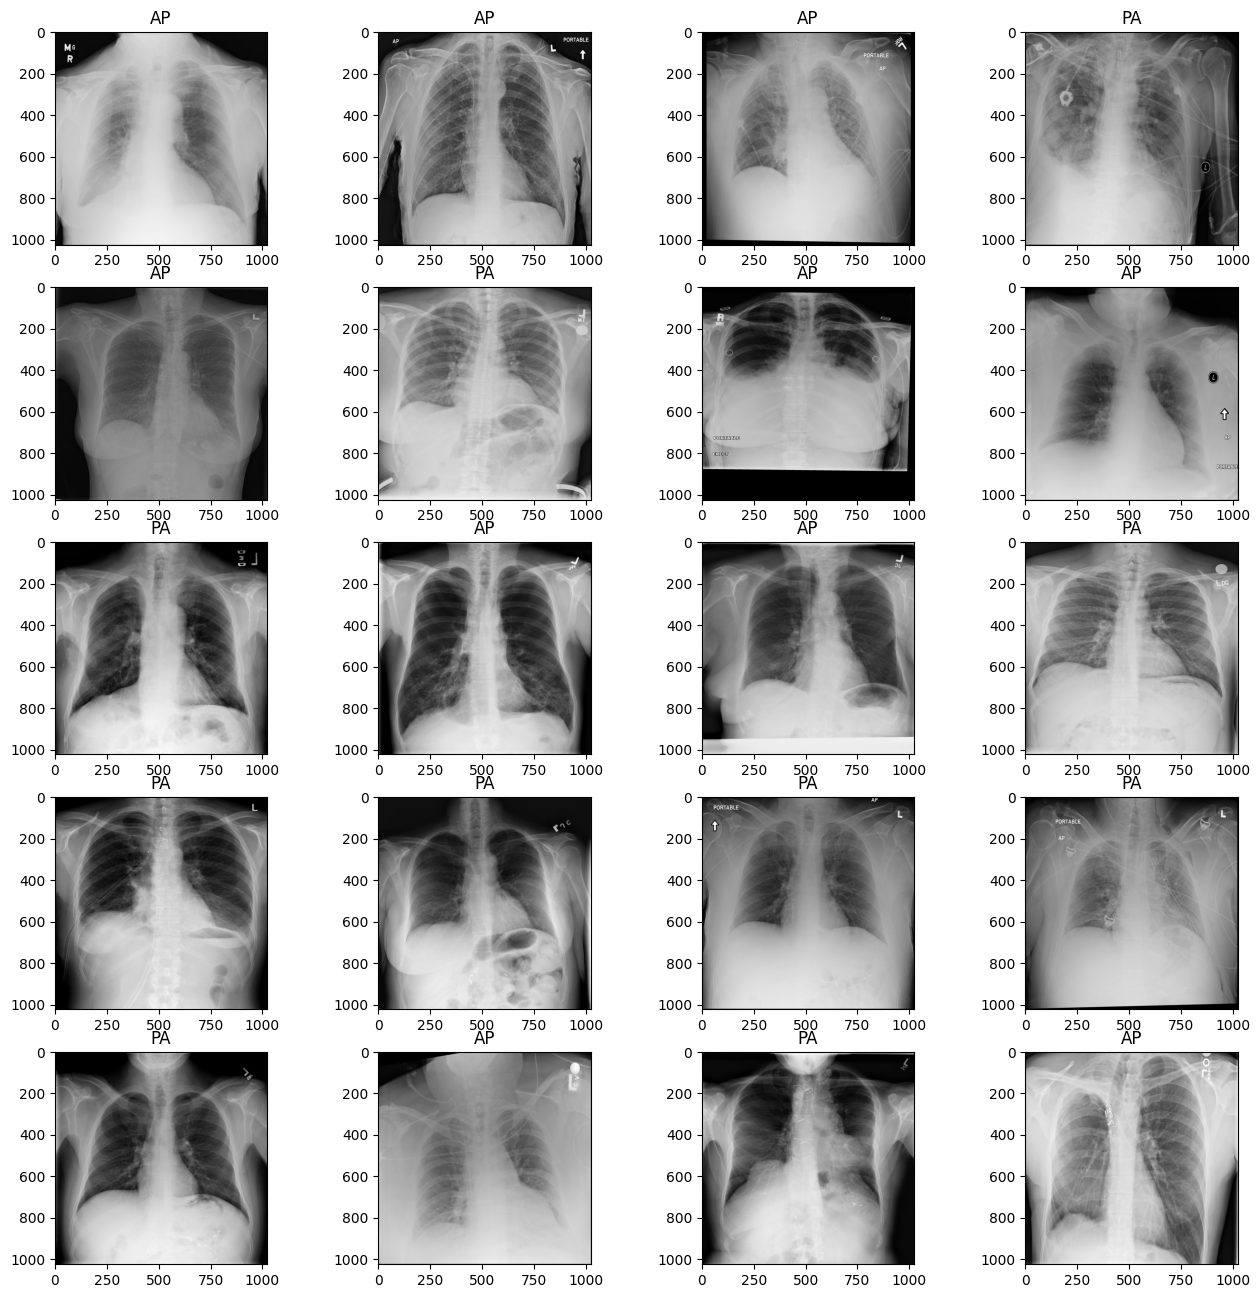

In [29]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = sample_df[sample_df['No Finding'] == 1]['path']
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(sample_df.iloc[ind]['View Position'])
    ind=ind+1

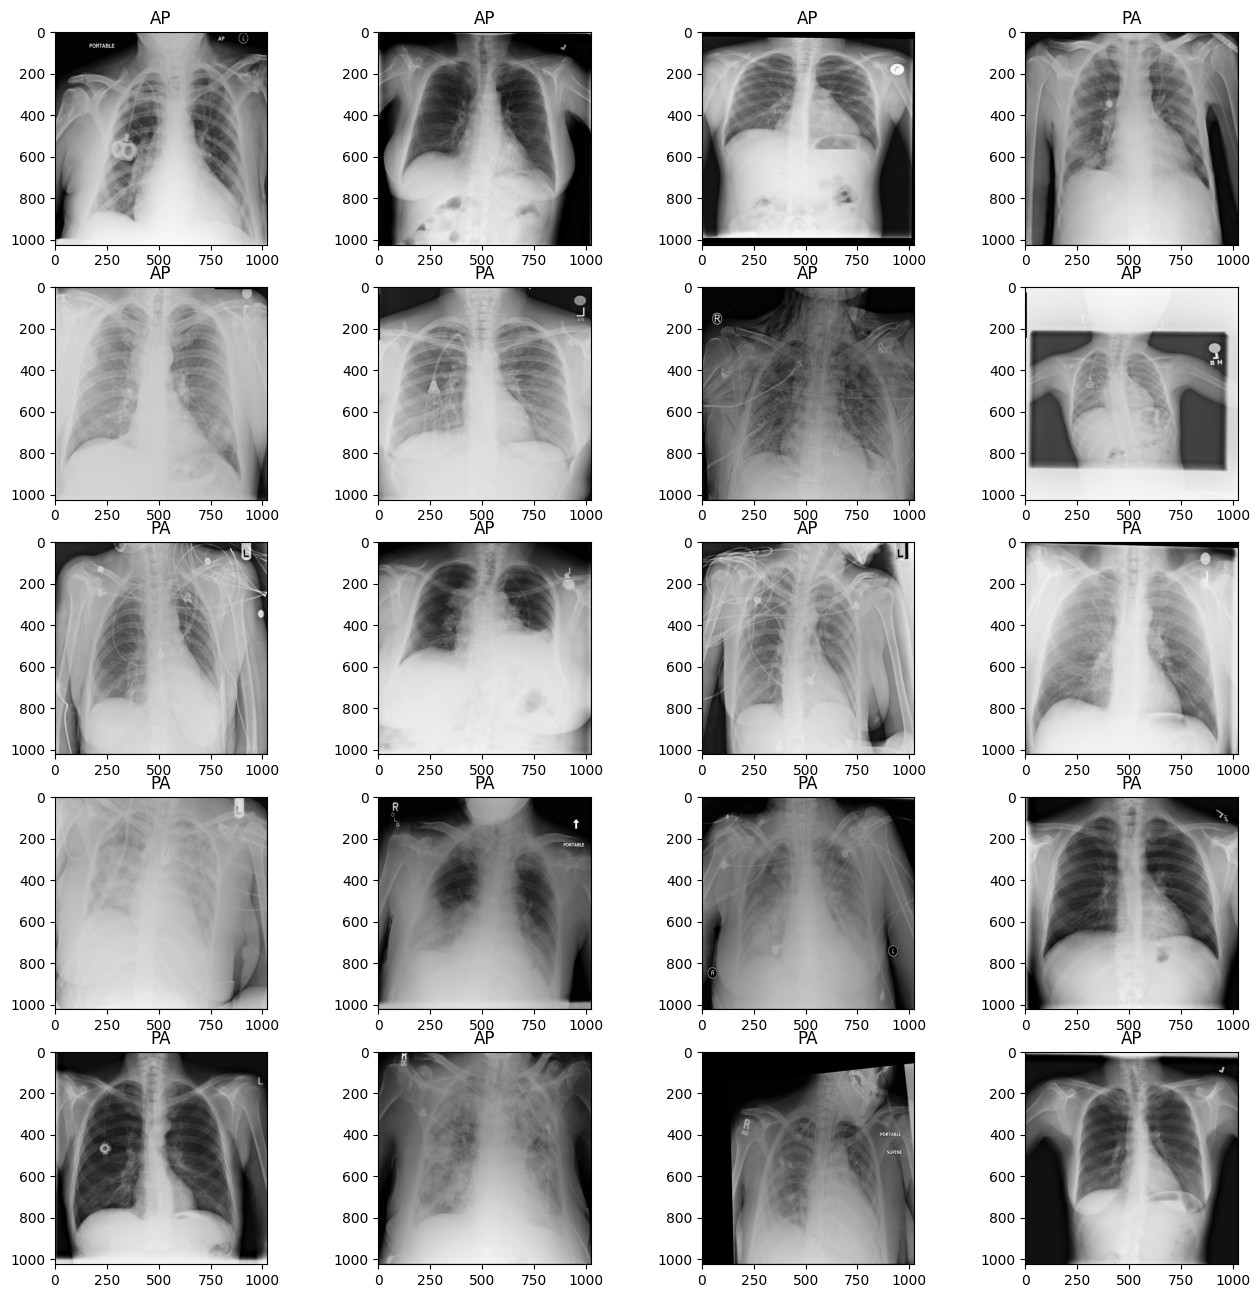

In [30]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = sample_df[sample_df['Pneumonia'] == 1]['path']
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(sample_df.iloc[ind]['View Position'])
    ind=ind+1

# Compare Histograns 

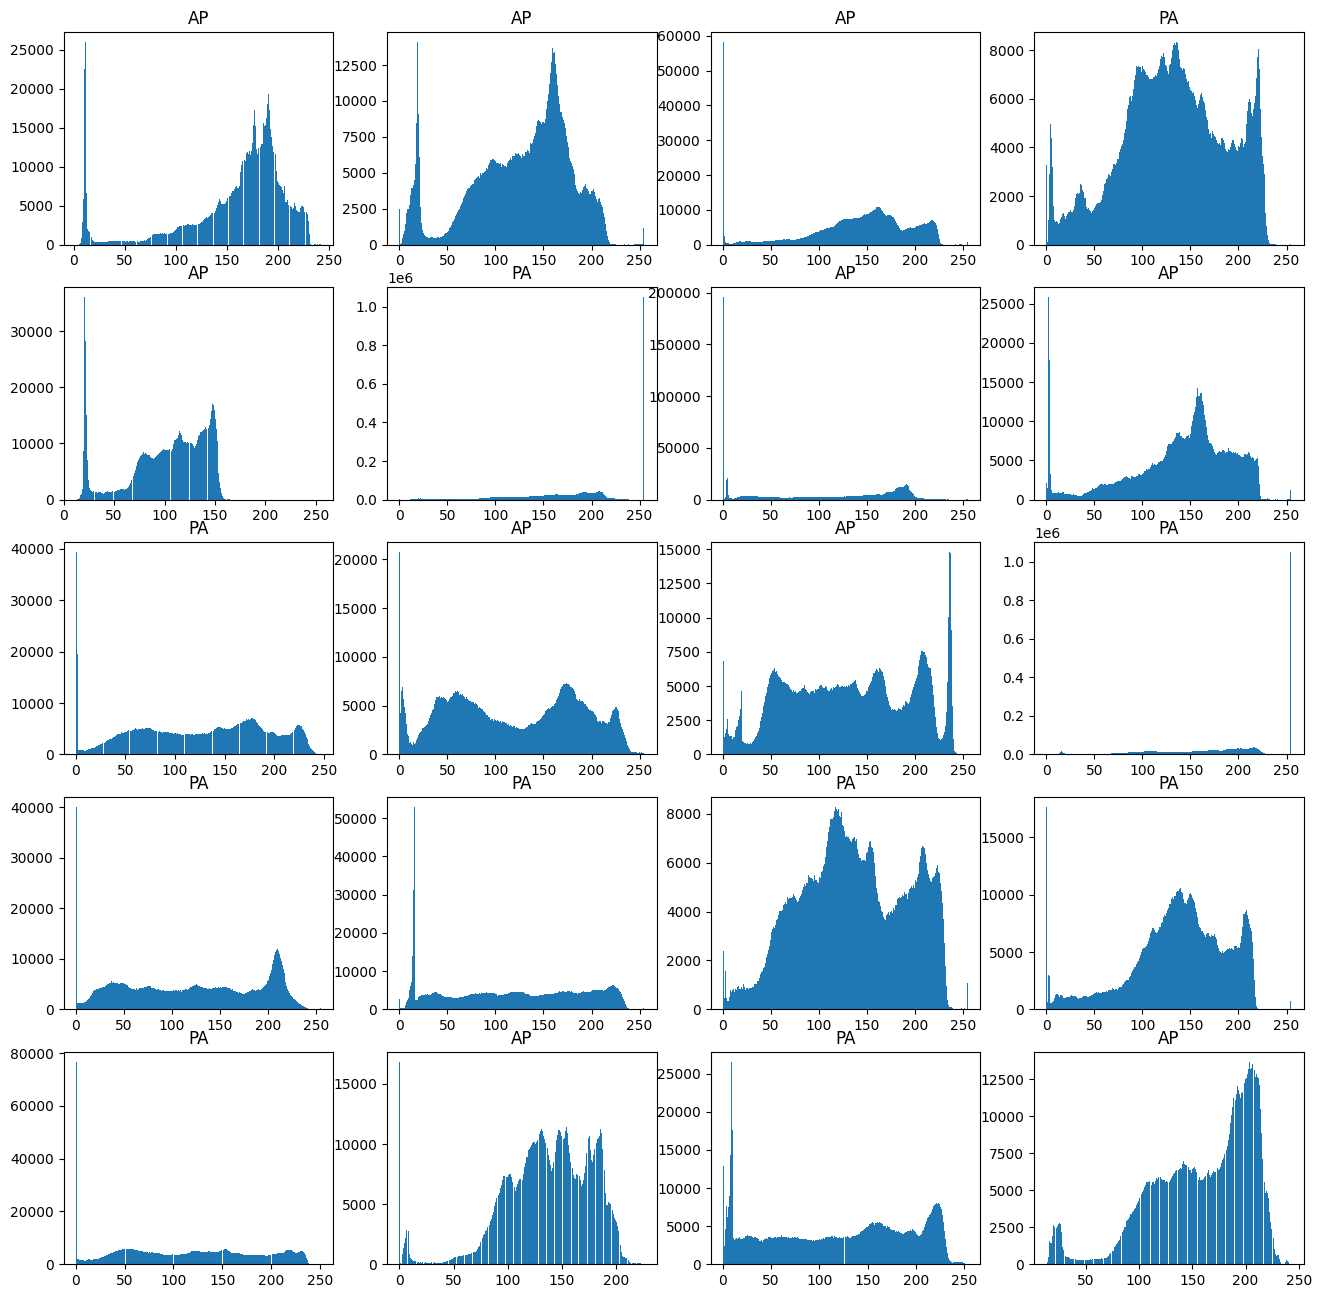

In [31]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = sample_df[sample_df['No Finding'] == 1]['path']
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins=256)
    ax.set_title(sample_df.iloc[ind]['View Position'])
    ind=ind+1


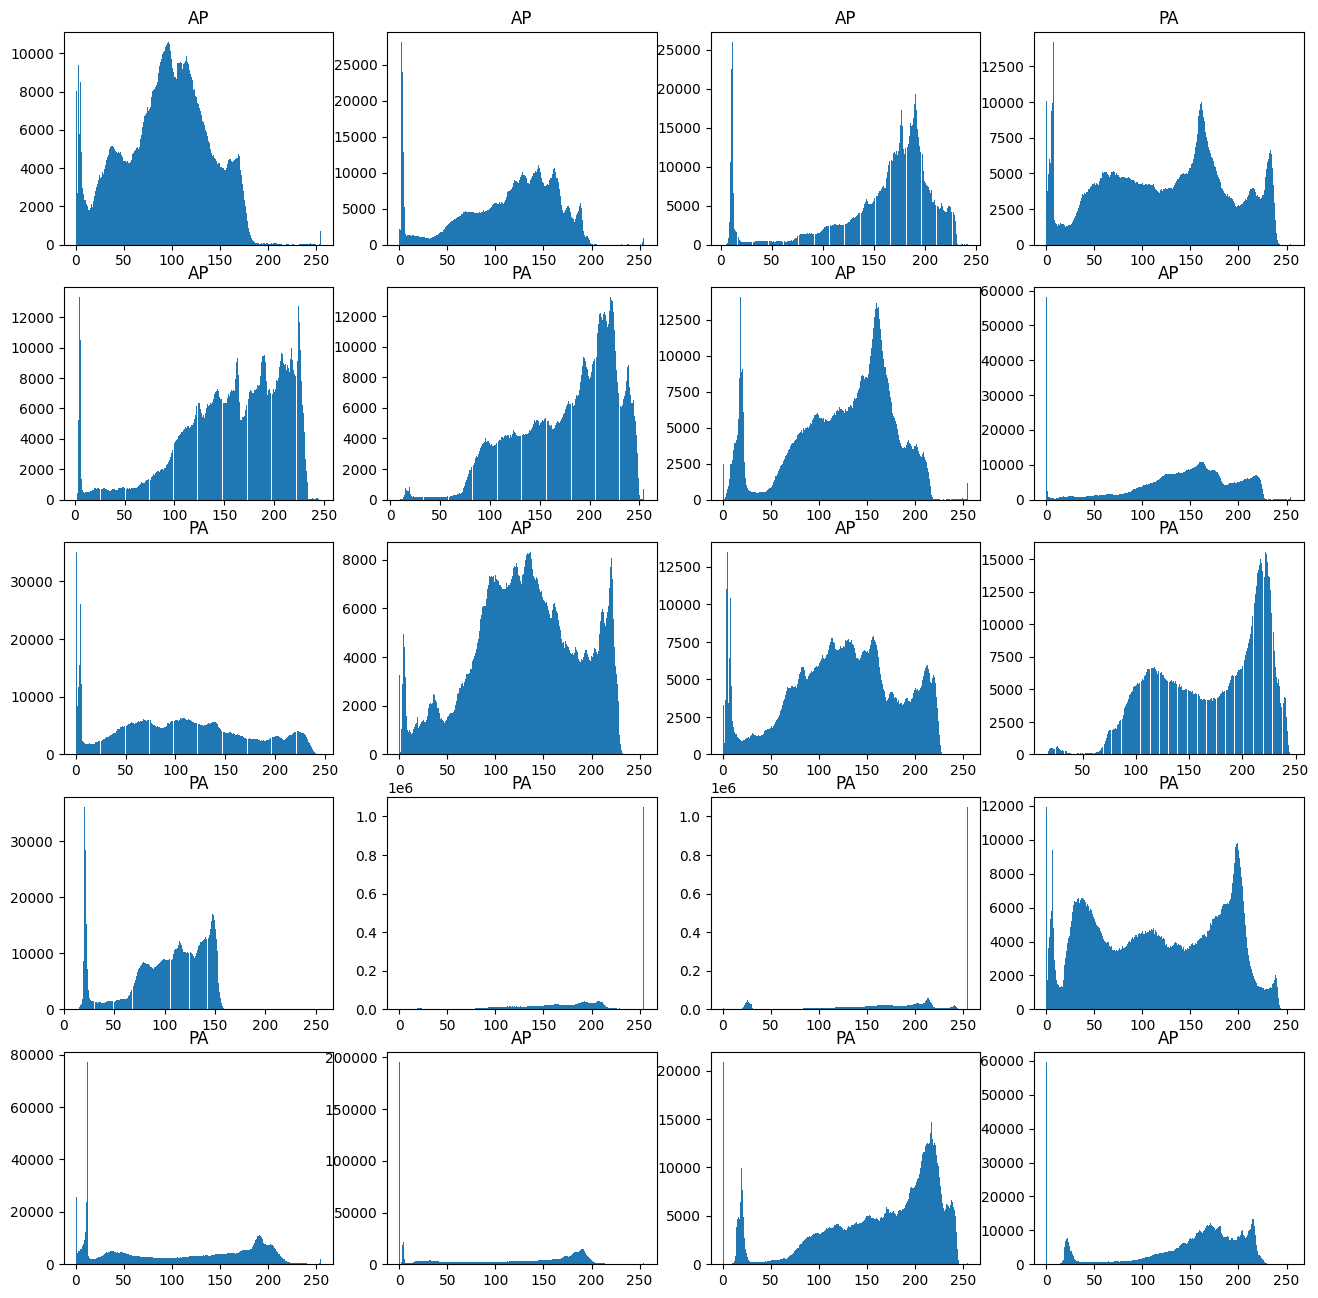

In [32]:
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = sample_df[sample_df['Pneumonia'] == 0]['path']
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.hist(img.ravel(), bins=256)
    ax.set_title(sample_df.iloc[ind]['View Position'])
    ind=ind+1


In [33]:
# Take a random sample of images with pneumonia only (cleanest possible signal)
pneumonia_paths = sample_df[sample_df["Pneumonia"] == 1]['path']

# Random sample of non-target images
non_target_paths = sample_df[sample_df["Pneumonia"] == 0]['path']

In [34]:

# Function to standardize pixels

def standardize_pixels(pixels):
    
    flatten_array = pixels.ravel()
    
    return (flatten_array - np.mean(flatten_array)) / np.std(flatten_array)

/tmp/ipykernel_5305/1888533972.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pneumonia_array = pd.Series()
/tmp/ipykernel_5305/1888533972.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  non_target_array = pd.Series()
/tmp/ipykernel_5305/1888533972.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pneumonia_array = pneumonia_array.append(pd.Series(temp_penumonia))
/tmp/ipykernel_5305/1888533972.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_target_array = pneumonia_array.append(pd.Series(temp_non_target))
/tmp/ipykernel_5305/1888533972.py:9: FutureWarning: Th

/tmp/ipykernel_5305/1888533972.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_target_array = pneumonia_array.append(pd.Series(temp_non_target))
/tmp/ipykernel_5305/1888533972.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pneumonia_array = pneumonia_array.append(pd.Series(temp_penumonia))
/tmp/ipykernel_5305/1888533972.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_target_array = pneumonia_array.append(pd.Series(temp_non_target))
/tmp/ipykernel_5305/1888533972.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pneumonia_array = pneumonia_array.append(pd.Series(temp_penumonia))
/tmp/ipykernel_5305/1888533972

/tmp/ipykernel_5305/1888533972.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pneumonia_array = pneumonia_array.append(pd.Series(temp_penumonia))
/tmp/ipykernel_5305/1888533972.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_target_array = pneumonia_array.append(pd.Series(temp_non_target))
/tmp/ipykernel_5305/1888533972.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pneumonia_array = pneumonia_array.append(pd.Series(temp_penumonia))
/tmp/ipykernel_5305/1888533972.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_target_array = pneumonia_array.append(pd.Series(temp_non_target))
/tmp/ipykernel_5305/1888533972

/tmp/ipykernel_5305/1888533972.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pneumonia_array = pneumonia_array.append(pd.Series(temp_penumonia))
/tmp/ipykernel_5305/1888533972.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_target_array = pneumonia_array.append(pd.Series(temp_non_target))
/tmp/ipykernel_5305/1888533972.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pneumonia_array = pneumonia_array.append(pd.Series(temp_penumonia))
/tmp/ipykernel_5305/1888533972.py:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  non_target_array = pneumonia_array.append(pd.Series(temp_non_target))
/tmp/ipykernel_5305/1888533972

<AxesSubplot: >

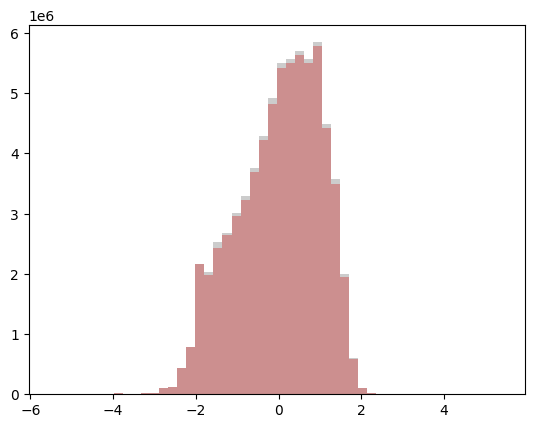

In [35]:

pneumonia_array = pd.Series()
non_target_array = pd.Series()

for i, x in enumerate(pneumonia_paths):
    
    # This should be a function
    temp_pneumonia = io.imread(x)
    temp_penumonia = standardize_pixels(temp_pneumonia)
    pneumonia_array = pneumonia_array.append(pd.Series(temp_penumonia))
    
    temp_non_target = io.imread(non_target_paths.iloc[i])
    temp_non_target = standardize_pixels(temp_non_target)
    non_target_array = pneumonia_array.append(pd.Series(temp_non_target))
    

sns.distplot(pneumonia_array, kde=False, color='red')
sns.distplot(non_target_array, kde=False, color='grey')    


As we can see, the pixel proximity of images with and without Pneumonia detections is extreme similar, so we can't pixel intensity alone to create our model, we will have to create a CNN to help us classify images.